In [49]:
# Neural Style Transfer with Computer Upload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
from google.colab import files
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# ================== 1. Image Upload ==================
print("Please upload your content and style images:")
uploaded = files.upload()

def load_uploaded_images():
    content_img = None
    style_img = None

    for filename in uploaded.keys():
        # Open and process each uploaded file
        img = Image.open(filename)
        img = np.array(img)

        # Convert RGBA to RGB if needed
        if img.ndim == 3 and img.shape[-1] == 4:
            img = img[..., :3]

        # Convert to tensor and normalize
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [512, 512])

        # Add batch dimension if needed
        if len(img.shape) == 3:
            img = img[tf.newaxis, ...]

        # Assign first image as content, second as style
        if content_img is None:
            content_img = img
            content_name = filename
        else:
            style_img = img
            style_name = filename

    print(f"\nLoaded:")
    print(f"- Content: {content_name}")
    print(f"- Style: {style_name}")
    return content_img, style_img


Please upload your content and style images:


Saving YellowLabradorLooking_new.jpg to YellowLabradorLooking_new (2).jpg
Saving Vassily_Kandinsky,_1913_-_Composition_7.jpg to Vassily_Kandinsky,_1913_-_Composition_7.jpg


In [50]:
def gram_matrix(input_tensor):
    if len(input_tensor.shape) == 3:
        input_tensor = input_tensor[tf.newaxis, ...]
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    return result / (tf.cast(input_shape[1]*input_shape[2], tf.float32))

# Initialize VGG19
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Layer setup
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Feature extractor
feature_extractor = tf.keras.Model(
    [vgg.input],
    [vgg.get_layer(name).output for name in style_layers + content_layers]
)

def run_style_transfer(content_img, style_img, epochs=10, style_weight=1e4, content_weight=1e0):
    # Extract features
    def extract_features(image):
        image = image * 255.0
        image = tf.keras.applications.vgg19.preprocess_input(image)
        return feature_extractor(image)

    style_features = extract_features(style_img)
    content_features = extract_features(content_img)

    # Style targets
    style_targets = [gram_matrix(feat) for feat in style_features[:len(style_layers)]]

    # Content targets
    content_targets = content_features[len(style_layers):]

    # Initialize result image
    generated_image = tf.Variable(content_img)
    opt = tf.optimizers.Adam(learning_rate=0.02)

    # Training loop
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            features = extract_features(generated_image)

            # Style loss
            style_loss = tf.add_n([
                tf.reduce_mean(tf.square(gram_matrix(features[i]) - style_targets[i]))
                for i in range(len(style_layers))
            ]) * (style_weight / len(style_layers))

            # Content loss
            content_loss = tf.add_n([
                tf.reduce_mean(tf.square(features[len(style_layers)+i] - content_targets[i]))
                for i in range(len(content_layers))
            ]) * (content_weight / len(content_layers))

            total_loss = style_loss + content_loss

        gradients = tape.gradient(total_loss, generated_image)
        opt.apply_gradients([(gradients, generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))

        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss.numpy():.2f}")

    return generated_image

In [62]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return Image.fromarray(tensor)




Loaded:
- Content: YellowLabradorLooking_new (2).jpg
- Style: Vassily_Kandinsky,_1913_-_Composition_7.jpg


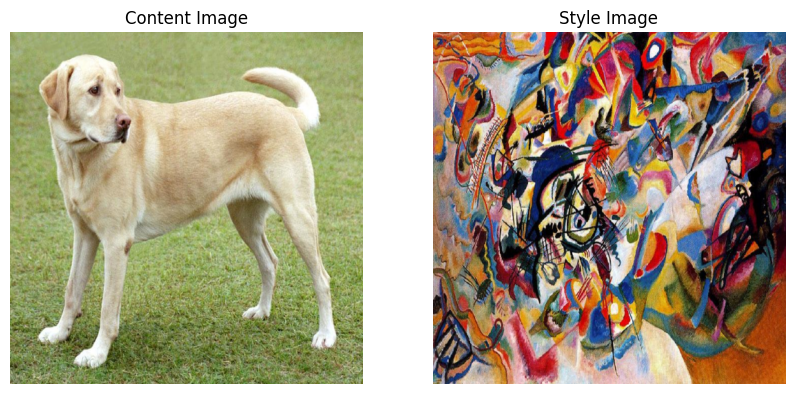


Starting style transfer...
Epoch 0: Loss = 914767904505856.00
Epoch 5: Loss = 194479290056704.00
Completed in 152.2 seconds


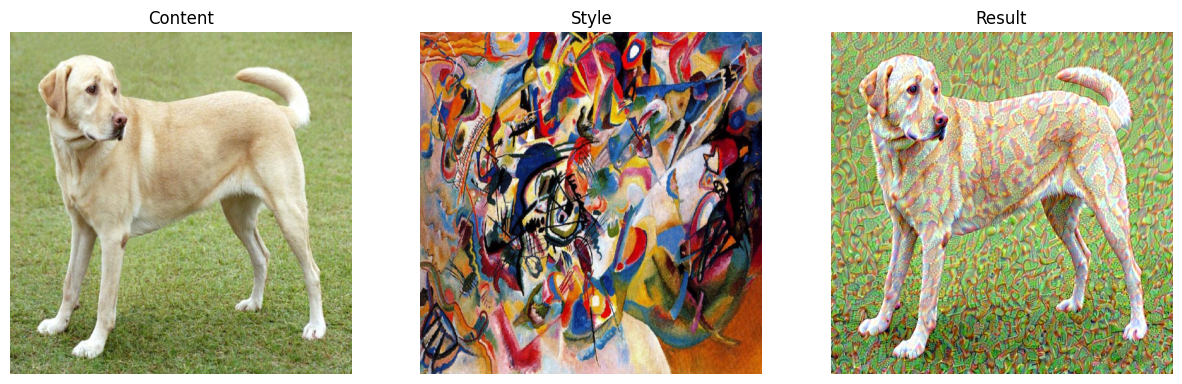

In [63]:
from IPython.display import HTML
import numpy as np
from PIL import Image
import io
import base64

if len(uploaded) >= 2:
    # Load uploaded images
    content_img, style_img = load_uploaded_images()

    # Display input images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(content_img[0])
    plt.title("Content Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(style_img[0])
    plt.title("Style Image")
    plt.axis('off')
    plt.show()

    # Run style transfer
    print("\nStarting style transfer...")
    start_time = time.time()
    result = run_style_transfer(content_img, style_img)
    print(f"Completed in {time.time()-start_time:.1f} seconds")

    # Show results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(content_img[0])
    plt.title("Content")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(style_img[0])
    plt.title("Style")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result[0])
    plt.title("Result")
    plt.axis('off')
    plt.show()

